# **4 - Ensamblaje**

En esta parte estaré ensamblando los distintos modelos que realicé con distintas técnicas. 
Primero importo todos los módulos que estaré usando. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg


Guardo los nombres de las carpetas en las que tengo guardadas las imágenes. 

In [2]:
train_folder = r'C:\Users\bertr\Desktop\UDD\Proyecto final\datos\train'
test_folder = r'C:\Users\bertr\Desktop\UDD\Proyecto final\datos\test'
val_folder = r'C:\Users\bertr\Desktop\UDD\Proyecto final\datos\val'

Aquí tengo el generador de imágenes que he estado usando a lo largo de todo el proyecto. Debido a que es un preprocesamiento a tiempo real, lo tengo que ir llamando otra vez para el entrenamiento de las imágenes. 

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Tamaño del batch. Mientras más pequeño sea, mejor aprenderá el modelo. 
batch_size = 32

#Se reescalan todas las imágenes para que tengan una resolución mucho más pequeña
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Agarramos las imágenes de sus respectivas carpetas, y las guardamos
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'  
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)


val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Cargo los 3 modelos que creé en el notebook anterior, y los guardo en variables con el mismo nombre. 

In [4]:
import pickle 
with open('model1.pkl', 'rb') as f:
    model1 = pickle.load(f)

In [5]:
with open('model2.pkl', 'rb') as f:
    model2 = pickle.load(f)

In [6]:
with open('model3.pkl', 'rb') as f:
    model3 = pickle.load(f)

c:\Users\bertr\anaconda3\envs\bootcmap\lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## **Ensamblaje 1 -- Averaging**

Este el primer ensamblaje que realizaré. Este es Avergaging (promedidador), en el cual simplemente predigo el valor de las imágenes, y se encuentra el promedio de este valor para luego encontrar el valor final. En las primeras líneas con el fit, entreno los modelos durante una época para que esten en uso. 

Luego genero predicciones con las imágenes de prueba, y guarda estas predicciones en una variable.

Encuentro el promedio de estas tres variables, y las guardo en una nueva variable. 

Por último, redondeo estos resultados para tenerlos todos guardados. Cambio los valores mayores a 0.5 a 1, y los valores menores a esto a 0. 

In [7]:
import numpy as np

# Train your models with the generators
model1.fit(train_generator, validation_data=val_generator, epochs=1)
model2.fit(train_generator, validation_data=val_generator, epochs=1)
model3.fit(train_generator, validation_data=val_generator, epochs=1)

# Generate predictions (probabilities) on the test set
preds_test_model1 = model1.predict(test_generator)
preds_test_model2 = model2.predict(test_generator)
preds_test_model3 = model3.predict(test_generator)

# Average the predictions
preds_test_ensemble = (preds_test_model1 + preds_test_model2 + preds_test_model3) / 3

# Convert averaged probabilities to binary predictions
final_preds_test = (preds_test_ensemble > 0.5).astype(int)

c:\Users\bertr\anaconda3\envs\bootcmap\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.9847 - loss: 0.0457 - val_accuracy: 0.8750 - val_loss: 0.2552
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 463ms/step - accuracy: 0.9659 - loss: 0.0993 - val_accuracy: 0.8750 - val_loss: 0.4370
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 489ms/step - accuracy: 0.7865 - loss: 0.4428 - val_accuracy: 0.6250 - val_loss: 0.8580
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 461ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
import seaborn as sns


In [13]:
accuracy = accuracy_score(y_test, final_preds_test)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6106


Aquí podemos ver el accuracy del modelo, que es de un 61 porciento aproximadamente. Esto no es tan bueno como los modelos entre sí. Veamos el resultado en una matriz de confusión. 

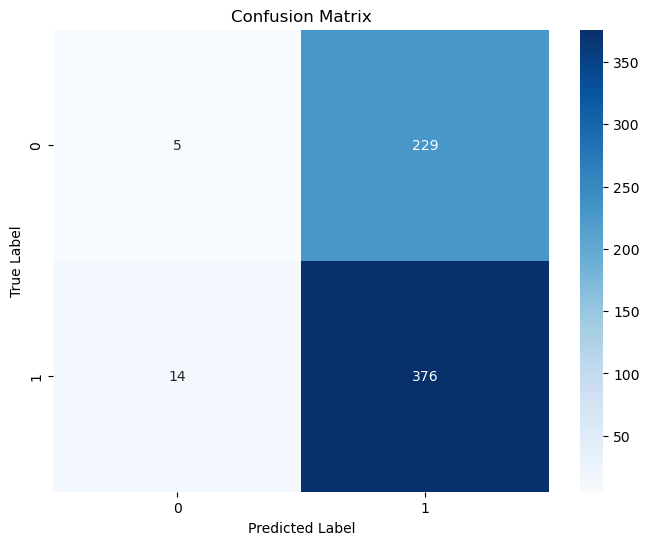

In [9]:
# Assuming y_test are the true labels from the test generator
y_test = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(y_test, final_preds_test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Debido a que se están pasando los generadores en las tres imagenes, tenemos muchos más datos de los que se tenían antes. Tenemos muchos verdaderos positivos y muchos falsos positivos. Tengamos en cuenta que los falsos positivos son bastante peligrosos, ya que el significado sería que alguien que tiene neumonía se dice que no lo tiene. Hay pocos falsos negativos, y muy pocos verdaderos 

## **Ensamblaje 2 -- VotingClassifier**

El segundo método de ensamblaje que usaré es VotingClassifier, en el que cada modelo crea su propia predicción, y luego cada uno vota acerca del valor que obtuvo. El valor con más votos es el resultado. Debido a que hay una cantidad impar de modelos, no habrán empates.

In [15]:
import numpy as np
from sklearn.ensemble import VotingClassifier

# Train your models
history1 = model1.fit(train_generator, validation_data=val_generator, epochs=1)
history2 = model2.fit(train_generator, validation_data=val_generator, epochs=1)
history3 = model3.fit(train_generator, validation_data=val_generator, epochs=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 458ms/step - accuracy: 0.9790 - loss: 0.0559 - val_accuracy: 0.8750 - val_loss: 0.3228
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 433ms/step - accuracy: 0.9716 - loss: 0.0813 - val_accuracy: 0.8750 - val_loss: 0.4989
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 0.9475 - loss: 0.1329 - val_accuracy: 0.6875 - val_loss: 0.6691


In [17]:
# Function to generate predictions
def get_predictions(model, generator):
    steps = generator.n // generator.batch_size + 1  # Make sure to include the remainder
    predictions = model.predict(generator, steps=steps, verbose=1)
    return predictions[:generator.n]  # Trim to the actual number of samples

# Generate predictions
preds_test_model1 = get_predictions(model1, test_generator)
preds_test_model2 = get_predictions(model2, test_generator)
preds_test_model3 = get_predictions(model3, test_generator)

# Convert probabilities to binary predictions
binary_preds_test_model1 = (preds_test_model1 > 0.5).astype(int)
binary_preds_test_model2 = (preds_test_model2 > 0.5).astype(int)
binary_preds_test_model3 = (preds_test_model3 > 0.5).astype(int)

# Stack predictions
X_test_preds = np.column_stack((binary_preds_test_model1, binary_preds_test_model2, binary_preds_test_model3))

# Get true labels
y_test = test_generator.classes

# Majority voting
final_preds_test = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=X_test_preds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step


In [18]:
from sklearn.metrics import precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_test, final_preds_test)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, final_preds_test)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, final_preds_test)
print(f'Recall: {recall:.4f}')

# Calculate F1-score
f1 = f1_score(y_test, final_preds_test)
print(f'F1-score: {f1:.4f}')

Accuracy: 0.6122
Precision: 0.6233
Recall: 0.9590
F1-score: 0.7556


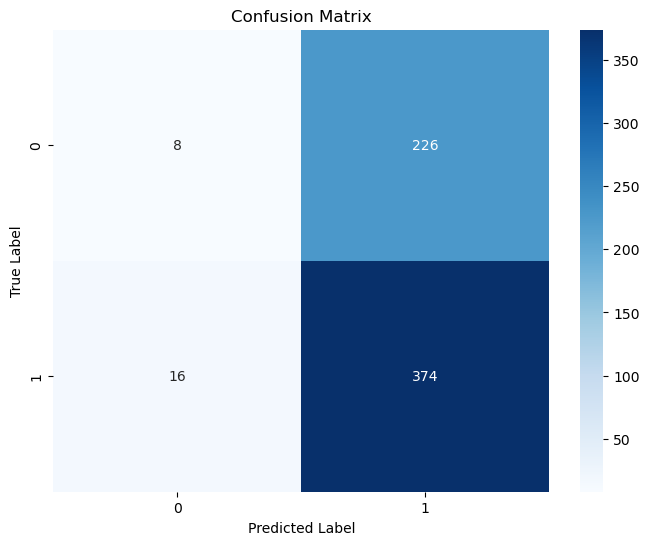

Ensemble Model Accuracy: 0.6121794871794872


In [20]:
# Evaluate the results

# Confusion Matrix
cm = confusion_matrix(y_test, final_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy
accuracy = accuracy_score(y_test, final_preds_test)
print(f'Ensemble Model Accuracy: {accuracy}')

Debido a que se están pasando los generadores en las tres imagenes, tenemos muchos más datos de los que se tenían antes. Tenemos muchos verdaderos positivos y muchos falsos positivos. Tengamos en cuenta que los falsos positivos son bastante peligrosos, ya que el significado sería que alguien que tiene neumonía se dice que no lo tiene. Hay pocos falsos negativos, y muy pocos verdaderos 

## **Ensamblaje 3 -- Stacking**

Stacking: combina las predicciones de múltiples modelos de base mediante un modelo de nivel superior (o meta-modelo) que aprende a optimizar las predicciones finales.


In [22]:
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the training data
train_preds_model1 = model1.predict(train_generator)
train_preds_model2 = model2.predict(train_generator)
train_preds_model3 = model3.predict(train_generator)

# Convert probabilities to binary predictions
train_binary_preds_model1 = (train_preds_model1 > 0.5).astype(int)
train_binary_preds_model2 = (train_preds_model2 > 0.5).astype(int)
train_binary_preds_model3 = (train_preds_model3 > 0.5).astype(int)

# Stack the predictions as new features
train_stack_features = np.column_stack((train_binary_preds_model1, train_binary_preds_model2, train_binary_preds_model3))

# Get the true labels
train_labels = train_generator.classes

# Define the meta-model
meta_model = LogisticRegression()

# Train the meta-model on the stacked features
meta_model.fit(train_stack_features, train_labels)

# Generate predictions on the test data
test_preds_model1 = model1.predict(test_generator)
test_preds_model2 = model2.predict(test_generator)
test_preds_model3 = model3.predict(test_generator)

# Convert probabilities to binary predictions
test_binary_preds_model1 = (test_preds_model1 > 0.5).astype(int)
test_binary_preds_model2 = (test_preds_model2 > 0.5).astype(int)
test_binary_preds_model3 = (test_preds_model3 > 0.5).astype(int)

# Stack the predictions as new features
test_stack_features = np.column_stack((test_binary_preds_model1, test_binary_preds_model2, test_binary_preds_model3))

# Make predictions using the meta-model
final_preds_test = meta_model.predict(test_stack_features)


163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 344ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 343ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 349ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step


In [23]:
# Evaluate the results
# Accuracy
accuracy = accuracy_score(test_generator.classes, final_preds_test)
print(f'Ensemble Model Accuracy: {accuracy}')

Ensemble Model Accuracy: 0.625


In [24]:
# Calculate precision
precision = precision_score(y_test, final_preds_test)
print(f'Precision: {precision:.4f}')

Precision: 0.6250


In [25]:
# Calculate recall
recall = recall_score(y_test, final_preds_test)
print(f'Recall: {recall:.4f}')

Recall: 1.0000


In [26]:
# Calculate F1-score
f1 = f1_score(y_test, final_preds_test)
print(f'F1-score: {f1:.4f}')

F1-score: 0.7692


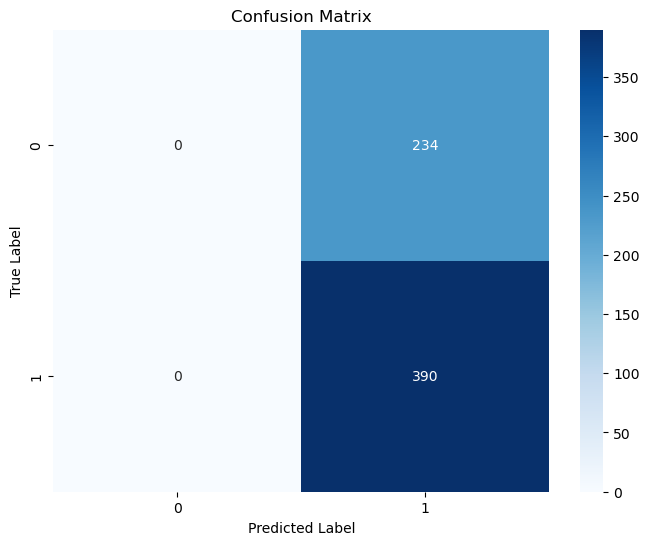

              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



c:\Users\bertr\anaconda3\envs\bootcmap\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bertr\anaconda3\envs\bootcmap\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bertr\anaconda3\envs\bootcmap\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [27]:

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, final_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

En esta celda, podemos ver que hay únicamente falsos positivos y verdaderos positivos. Como ya se ha dicho numerosas veces a lo largo del proyecto, es bastante peligroso tener muchos de estos debido a que dice que el paciente no tiene neumonía cuando si la tiene. 

## **Conclusiones**

En conclusión, he decidido tomar el modelo de VotingClassifier como el que me llevaré a producción, debido a que es el que menos falsos positivos tiene. 